In [1]:
from argparse import ArgumentParser, Namespace
from collections import Counter
from pathlib import Path
import pickle
import sys
from typing import List, Tuple

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm, trange

In [2]:
sns.set_context("talk")

In [3]:
from IPython.display import HTML

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
sys.path.append(str(Path(".").resolve().parent))
import berp.models.reindexing_regression as rr

In [6]:
IS_INTERACTIVE = False
try:
    get_ipython()  # type: ignore
except NameError: pass
else: IS_INTERACTIVE = True
IS_INTERACTIVE

True

In [7]:
p = ArgumentParser()
p.add_argument("natural_language_stimulus_path", type=Path)
p.add_argument("confusion_path", type=Path)

_StoreAction(option_strings=[], dest='confusion_path', nargs=None, const=None, default=None, type=<class 'pathlib.Path'>, choices=None, required=True, help=None, metavar=None)

In [8]:
if IS_INTERACTIVE:
    args = Namespace(natural_language_stimulus_path=Path("gillis2021/DKZ_1.pkl"),
                     confusion_path=Path("gillis2021/confusion.npz"))
else:
    args = p.parse_args()

In [9]:
with args.natural_language_stimulus_path.open("rb") as f:
    stim = pickle.load(f)
confusion = np.load(args.confusion_path)

In [10]:
assert confusion["phonemes"].tolist() == stim.phonemes

In [11]:
confusion_matrix = torch.tensor(confusion["confusion"])

# Smooth and normalize.
confusion_matrix += 1.
confusion_matrix /= confusion_matrix.sum(dim=0, keepdim=True)

In [11]:
p_candidates = rr.predictive_model(
    stim.p_word, stim.candidate_phonemes,
    confusion=confusion_matrix,
    lambda_=torch.tensor(1.),  # TODO,
    return_gt_only=False)

In [51]:
# Nested array. Outer list of words and inner list of phonemes per word.
plot_data: List[List[Tuple[str, float]]] = []

k = 10
for prior_i, p_candidates_i, candidates, gt_length in zip(stim.p_word.exp(), tqdm(p_candidates), stim.candidate_phonemes, stim.word_lengths):
    candidate_strs = ["".join(stim.phonemes[idx.item()].rstrip("_") for idx in word)
                      for word in candidates]
    plot_data_i = []
    
    p_candidates_i = p_candidates_i.T[:gt_length]
    # Add prior information, before any phonemes arrive
    p_candidates_i = torch.cat([prior_i[None, :], p_candidates_i], dim=0)
    p_candidates_i = p_candidates_i.numpy()
    
    topk = (-p_candidates_i).argsort(1)[:, :k * 2]
    p_candidates_i = np.take_along_axis(p_candidates_i, topk, 1)
    gt_str = candidate_strs[0]

    for t, (p_candidates_t, candidates_t) in enumerate(zip(p_candidates_i, topk)):
        # Merge candidates with same form.
        # HACK
        weights = Counter()
        for p, idx in zip(p_candidates_t, candidates_t):
            weights[candidate_strs[idx]] += p
        
        plot_data_i.append((gt_str[:t], list(weights.most_common(k))))
        
    plot_data.append(plot_data_i)

  0%|          | 0/2190 [00:00<?, ?it/s]

In [52]:
plot_data[4]

[('',
  [('də', 0.28163793683052063),
   ('ət', 0.10158157348632812),
   ('ən', 0.06767095346003771),
   ('har', 0.06442450731992722),
   ('zɛin', 0.022922245785593987),
   ('di', 0.022135790437459946),
   ('mɛin', 0.013712789863348007),
   ('dɛn', 0.011273816227912903),
   ('ɑlə', 0.011011981405317783),
   ('dɑt', 0.010734261944890022)]),
 ('z',
  [('zɛin', 0.39956001305000555),
   ('zɛt', 0.06738343080691557),
   ('ze', 0.061105530151308),
   ('stat', 0.036439314088812826),
   ('zwɑrtə', 0.03214291630035311),
   ('zhzlf', 0.028639134919081898),
   ('zwɑrt', 0.019270885120121633),
   ('zh', 0.014697466577617656),
   ('stɪltə', 0.013704756683494914),
   ('ət', 0.01324443280426489)]),
 ('ze',
  [('ze', 0.5945038367072579),
   ('zekərə', 0.07864513707975736),
   ('zɛin', 0.05361893176694422),
   ('zevə', 0.03692778882829037),
   ('zɛt', 0.03617006167437919),
   ('zer', 0.02382346204645585),
   ('zɪlvər', 0.020003087618346176),
   ('zɪt', 0.018875649903959353),
   ('zekər', 0.016707254303

In [54]:
" ".join(to_gt_words(np.arange(50)))

'klɛinə zemermɪnməɔp vɛr ɪn ze ɪs ət watər zo blɑuw ɑls də blatjəs vɑn də mojstə korənblumr ɛn zo hɛldər ɑls ət zœyjvərstə xlɑs mar ɪsəhil dip dipər dɑn ən ɑŋkərkɛtɪŋ ojt kɑn koməx jə zɑu ən heləbul kɛrktorəns bovən ɔp ɛlkar mutə zɛtədr ɔm vɑn də bodəm vɑn də'

In [77]:
" ".join(to_gt_words(np.arange(160, 170)))

'də bəwexɪŋə vɑn ətdə watər opən ɛn dɪxt xan ɛt'

In [107]:
class PredictiveAnimation:
    
    def __init__(self, plot_data, k=3, threshold=0.7):
        self.plot_data = plot_data
        # Mapping between frame index and plot_data nested index.
        self.plot_idxs_flat = [(i, j) for i in range(len(plot_data)) for j in range(len(plot_data[i]))]

        self.k = k
        self.threshold = threshold
        
    def _prepare_figure(self):
        self.fig, self.ax = plt.subplots(dpi=200)

        self.ax.set_xlim((0, 1))
        self.ax.set_xlabel("Evidence for word")
        self.ax.set_ylabel("Word")

        self.bar = self.ax.barh([str(i) * 7 for i in range(self.k)], [0] * self.k)
        self.threshold_line = self.ax.axvline(self.threshold, color="gray", linestyle="--")
        self.prev_label = self.ax.annotate("", (0.49, 1.05), xycoords="axes fraction", ha="right")
        self.incremental_label = self.ax.annotate("abc", (0.5, 1.05), xycoords="axes fraction")
        self.prev_incremental_text = [None]
        self.acc_text = []
        
        plt.tight_layout()
        
    def get_first_frame_for_word_idx(self, word_idx):
        return next(i for i, (word_idx_i, _) in enumerate(self.plot_idxs_flat) if word_idx_i == word_idx)
        
    def animate(self, i):
        token_idx, incremental_idx = self.plot_idxs_flat[i]
        incremental_text, incremental_dist = self.plot_data[token_idx][incremental_idx]
        print(incremental_text)
        print(incremental_dist)

        xticklabels = self.ax.get_xticklabels()
        artists = list(self.bar) + xticklabels

        for i, ((option_i, p_i), bar_i, label_i) in enumerate(zip(incremental_dist, self.bar, xticklabels)):
            bar_i.set_width(p_i)

            # Doesn't work .. do it differently below
            # label_i.set_text(option_i)

        self.ax.set_yticklabels([option_i for option_i, _ in incremental_dist])
        self.ax.tick_params("y", width=10)

        if self.prev_incremental_text[0] is not None and not incremental_text.startswith(self.prev_incremental_text[0]):
            print("----", self.prev_incremental_text)
            self.acc_text.append(self.prev_incremental_text[0])
            self.prev_label.set_text(" ".join(self.acc_text))
            artists.append(self.prev_label)

        self.incremental_label.set_text(incremental_text)
        artists.append(self.incremental_label)
        self.prev_incremental_text[0] = incremental_text

        return artists
    
    def plot(self, start_frame=None, n_frames=100, **kwargs):
        plt.ioff()
        if start_frame is None: start_frame = 0
        
        default_kwargs = dict(blit=True, repeat=True, interval=750)
        default_kwargs.update(kwargs)
        
        self._prepare_figure()
        anim = FuncAnimation(self.fig, self.animate, frames=list(range(start_frame, start_frame + n_frames)),
                             **default_kwargs)
        return anim
    
    def plot_for_word(self, word_idx=None, num_prior_frames=0, **kwargs):
        start_frame = self.get_first_frame_for_word_idx(word_idx)
        start_frame = max(0, start_frame - num_prior_frames)
        return self.plot(start_frame, n_frames=stim.word_lengths[word_idx].item() + num_prior_frames + 1,
                         **kwargs)

k
[('ka', 0.07690271089446751), ('kamər', 0.05384486567243874), ('kɪndərə', 0.04396858225036697), ('kɑns', 0.04155880334183678), ('klɛinə', 0.038866134316553676), ('konɪŋ', 0.03171127834680249), ('kɛrk', 0.024598742157182458), ('krht', 0.023814558275841852), ('krɑnt', 0.022873860811261606), ('kwɛsti', 0.02242023353544918)]


/tmp/ipykernel_55716/3588190549.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for option_i, _ in incremental_dist])


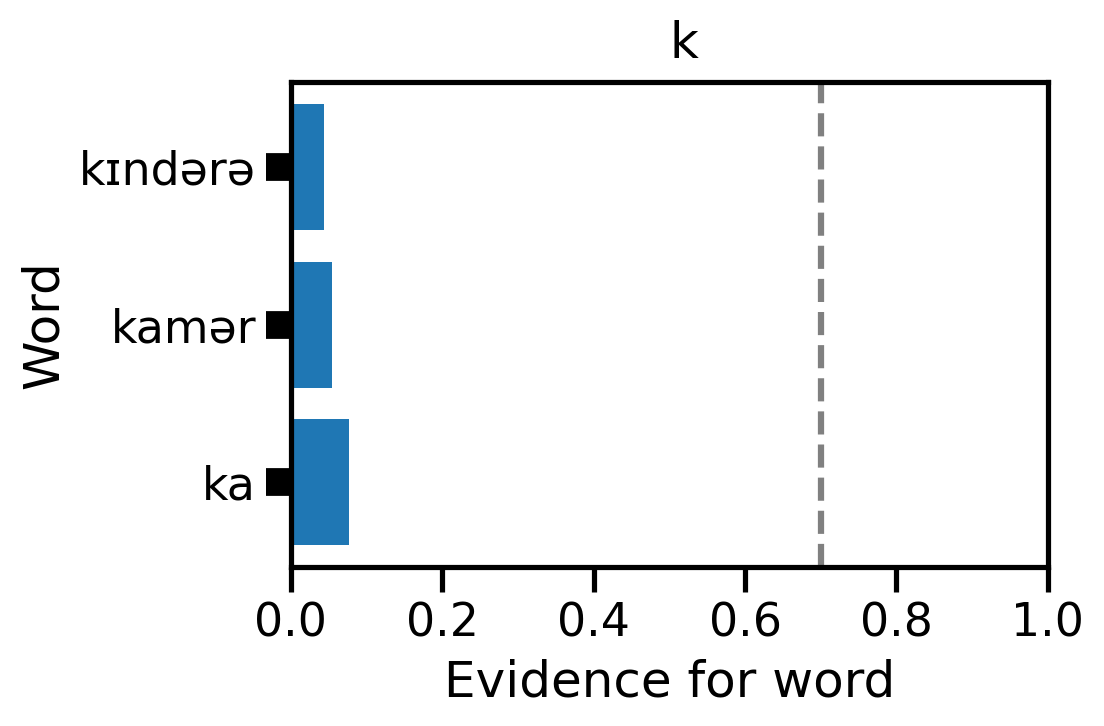

In [116]:
anim = PredictiveAnimation(plot_data).plot(n_frames=1, start_frame=1)
# HTML(anim.to_html5_video())

In [117]:
anim.save("test.mp4", dpi=200)

k
[('ka', 0.07690271089446751), ('kamər', 0.05384486567243874), ('kɪndərə', 0.04396858225036697), ('kɑns', 0.04155880334183678), ('klɛinə', 0.038866134316553676), ('konɪŋ', 0.03171127834680249), ('kɛrk', 0.024598742157182458), ('krht', 0.023814558275841852), ('krɑnt', 0.022873860811261606), ('kwɛsti', 0.02242023353544918)]
k
[('ka', 0.07690271089446751), ('kamər', 0.05384486567243874), ('kɪndərə', 0.04396858225036697), ('kɑns', 0.04155880334183678), ('klɛinə', 0.038866134316553676), ('konɪŋ', 0.03171127834680249), ('kɛrk', 0.024598742157182458), ('krht', 0.023814558275841852), ('krɑnt', 0.022873860811261606), ('kwɛsti', 0.02242023353544918)]


/tmp/ipykernel_55716/3588190549.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for option_i, _ in incremental_dist])


### MAP due to high-prior

In [78]:
high_prior_words = [(i, word_dat[-1][0], word_dat)
                    for i, word_dat in enumerate(plot_data)
                    if word_dat[0][1][0][0] == word_dat[-1][0]
                    # exclude words which are high prior for uninteresting reasons (because the prior space is not big enough .. need top-p sampling)
                    and len(word_dat[-1][0]) < 5]

In [79]:
sorted(high_prior_words, key=lambda x: -len(x[1]))[3]

(167,
 'dɪxt',
 [('',
   [('dɪxt', 0.1719481348991394),
    ('blot', 0.09509650617837906),
    ('opə', 0.06402429193258286),
    ('œyt', 0.028691165149211884),
    ('ɪn', 0.0214782003313303),
    ('drox', 0.019977770745754242),
    ('tu', 0.013684075325727463),
    ('nar', 0.012398803606629372),
    ('slœytə', 0.010402991436421871),
    ('də', 0.010357849299907684)]),
  ('d',
   [('dɪxt', 0.61737166223976),
    ('drox', 0.07172924759194947),
    ('də', 0.03718937009403986),
    ('tu', 0.02929024763418044),
    ('blot', 0.01969843378139855),
    ('dor', 0.018604644911149392),
    ('drɪŋə', 0.015236193170913114),
    ('dɑn', 0.013799242074631249),
    ('texə', 0.013145061270201578),
    ('dip', 0.010067589564752412)]),
  ('dɪ',
   [('dɪxt', 0.9653905482928359),
    ('texə', 0.01807239749416104),
    ('dip', 0.0022929115965258265),
    ('de', 0.002065638304860151),
    ('dɪk', 0.0019112763150488242),
    ('bɪnə', 0.0015030859899795555),
    ('də', 0.0011362122415435794),
    ('drox', 0.00

In [127]:
# Plot up through the next word
plot_data_copy = plot_data[:]
plot_data[164] = [('',
  [('dɑk', 0.08090640604496002),
   ('shp', 0.0518440380692482),
   ('vatər', 0.039041485637426376),
   ('lht', 0.025143694132566452),
   ('zɛil', 0.01924835331737995),
   ('lhm', 0.017056478187441826),
   ('hoft', 0.01666797697544098),
   ('vyr', 0.01598547026515007),
   ('dɛksəl', 0.011327615939080715),
   ('hɑrt', 0.009778285399079323)]),
 ('v',
  [('vatər', 0.31085636171357267),
   ('dɑk', 0.07465420090525711),
   ('vil', 0.05635946200083533),
   ('vezə', 0.021059028275048835),
   ('vɛrk', 0.02046381286515716),
   ('vyr', 0.02022199515918633),
   ('varə', 0.01878380868150893),
   ('vɪnt', 0.015006180916906002),
   ('wapə', 0.014973473024963177)]),
 ('va',
  [('vatər', 0.7632859928210007),
   ('varə', 0.046122324727058246),
   ('vapə', 0.03676631277814532),
   ('dɑk', 0.028737145298473807),
   ('part', 0.009795768002742533),
   ('vaxə', 0.006303714224540907),
   ('man', 0.004963951013249169),
   ('vartœyx', 0.004081984810033973),
   ('kanɔn', 0.0026312483343444615)]),
 ('vat',
  [('vatər', 0.9479935884659999),
   ('dɑk', 0.002618276863880728),
   ('bœytə', 0.002303729608285961),
   ('vapə', 0.0015867588539546984),
   ('materijal', 0.0010616164199207369),
   ('bɑt', 0.0009658065051589363),
   ('vat', 0.0009508126130128344),
   ('pɑt', 0.0008746246013960802),
   ('hɑut', 0.0006378571137768702)]),
 ('vatə',
  [('vatər', 0.9589398391727376),
   ('bœytə', 0.0023303302120871324),
   ('vapə', 0.0016050807713577774),
   ('varə', 0.0004474510070396444),
   ('natyr', 0.0001599409015909945),
   ('makə', 0.00014662602969521668),
   ('hɑutə', 0.00012367573956455048),
   ('vɪtə', 0.00010058485048974868),
   ('nɑtə', 7.793908764115418e-05)]),
 ('vatər',
  [('vatər', 0.9638234100118517),
   ('natyr', 0.00016075542893784556),
   ('materijal', 6.287438111222813e-05),
   ('papir', 5.064496067323334e-06),
   ('bœytə', 3.3846789466788525e-06),
   ('vapə', 2.3312932503535646e-06),
   ('hamər', 2.1158096432743994e-06),
   ('lɑdər', 1.394293481705988e-06),
   ('motɔr', 9.763669695184297e-07)])]
anim = PredictiveAnimation(plot_data, k=5).plot_for_word(168, num_prior_frames=13, interval=1000)
anim.save("high_prior.gif", dpi=200)
plt.close()


[('zɛin', 0.06724528968334198), ('ɪn', 0.054422006011009216), ('də', 0.038615141063928604), ('dor', 0.03749451786279678), ('ɔp', 0.03518792241811752), ('wɔrdə', 0.03289197012782097), ('nar', 0.022209344431757927), ('ən', 0.021747896447777748), ('ovər', 0.019942374899983406), ('ət', 0.013411987572908401)]

[('zɛin', 0.06724528968334198), ('ɪn', 0.054422006011009216), ('də', 0.038615141063928604), ('dor', 0.03749451786279678), ('ɔp', 0.03518792241811752), ('wɔrdə', 0.03289197012782097), ('nar', 0.022209344431757927), ('ən', 0.021747896447777748), ('ovər', 0.019942374899983406), ('ət', 0.013411987572908401)]

[('zɛin', 0.06724528968334198), ('ɪn', 0.054422006011009216), ('də', 0.038615141063928604), ('dor', 0.03749451786279678), ('ɔp', 0.03518792241811752), ('wɔrdə', 0.03289197012782097), ('nar', 0.022209344431757927), ('ən', 0.021747896447777748), ('ovər', 0.019942374899983406), ('ət', 0.013411987572908401)]


/tmp/ipykernel_55716/3588190549.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for option_i, _ in incremental_dist])
/tmp/ipykernel_55716/3588190549.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for option_i, _ in incremental_dist])


o
[('ovər', 0.3543567491620485), ('ɔp', 0.17679636134010865), ('opən', 0.049198475800448484), ('ɔndər', 0.04913878293419273), ('ɔmhox', 0.048421267424914254), ('ɔf', 0.03552644190370118), ('ok', 0.02125709574211819), ('ɔntsnɑpə', 0.016082074073402893), ('wɔrdə', 0.014359542201483317), ('ɔm', 0.013589453109334314)]
op
[('ɔp', 0.7034904893216959), ('opən', 0.19507816423003316), ('ɔplɔsə', 0.014457146049386761), ('ɔpsɛi', 0.013817224989326993), ('ɔpfɑŋə', 0.009738111688512532), ('ovər', 0.00846427242077243), ('ok', 0.006854671091848079), ('ɔplopə', 0.004760407382924574), ('ɔpstɛixə', 0.004200596074443193), ('ɔphɑudə', 0.003585949572311377)]
opə
[('opən', 0.9263711785604772), ('ovər', 0.04019444231001598), ('ɔp', 0.016159930499384068), ('ɔpərvlɑk', 0.00898745201405662), ('ovərdɛkt', 0.0009528133804201374), ('ɔplɔsə', 0.0009373121655129384), ('ovərhen', 0.0006720058010758989), ('ovərbort', 0.0006447743405001305), ('ɔphɑudə', 0.0003771518217003892), ('ɔpsɛi', 0.0003583294526287214)]
opən
[('

### Low-prior but high posterior

In [111]:
low_prior_high_post_words = [
    (i, word_dat[-1][0], word_dat)
     for i, word_dat in enumerate(tqdm(plot_data))
     if len(word_dat) >= 3
     # not in top K for first two phonemes
     and not any(opt_name == word_dat[-1][0] for opt_name, _ in word_dat[0][1] + word_dat[1][1])
     and any(opt_name == word_dat[-1][0] for opt_name, _ in word_dat[2][1])
     # exclude words which are high prior for uninteresting reasons (because the prior space is not big enough .. need top-p sampling)
     # and len(word_dat[-1][0]) < 5
]

In [112]:
low_prior_high_post_words[0]

(12,
 'blatjəs',
 [('',
   [('zon', 0.16980303823947906),
    ('man', 0.11944219470024109),
    ('ze', 0.06850098073482513),
    ('heməl', 0.037698451429605484),
    ('n', 0.024974441155791283),
    ('wɪnt', 0.018816784024238586),
    ('lht', 0.017013946548104286),
    ('ardə', 0.016627047210931778),
    ('dɑx', 0.013016915880143642),
    ('xrɔnt', 0.011706178076565266)]),
  ('b',
   [('brɑndɪŋ', 0.12174686418616801),
    ('blɑuwə', 0.10131895231041016),
    ('blɪksəm', 0.05669878913118321),
    ('blumə', 0.033443067972568775),
    ('bodəm', 0.03267060337267892),
    ('bladərə', 0.028025995592028032),
    ('bɛrxə', 0.024119032711436415),
    ('blɑuw', 0.023631604931228088),
    ('be', 0.023353971982981978),
    ('bomə', 0.02144634787127878)]),
  ('bl',
   [('blɑuwə', 0.29535128971985214),
    ('blɪksəm', 0.1652806322369393),
    ('blumə', 0.09748870307724247),
    ('bladərə', 0.08169758722364803),
    ('blɑuw', 0.06888765463350632),
    ('blatjəs', 0.060614372664934364),
    ('blut', 0

In [119]:
# Plot up through the next word
anim = PredictiveAnimation(plot_data, k=5).plot_for_word(13, num_prior_frames=21, interval=1000)
anim.save("low_prior.gif", dpi=200)
plt.close()

zo
[('zo', 0.916083393619775), ('zowɑls', 0.03387829818746298), ('zɔndər', 0.009934871585879083), ('zodanəx', 0.004927472420855347), ('zovel', 0.0035504252107171628), ('zovɛr', 0.003195231873743002), ('zodra', 0.002874081501498377), ('shn', 0.002551965636282473), ('zolɑŋ', 0.0022934463790011002), ('zht', 0.0019439855326033846)]


/tmp/ipykernel_55716/3588190549.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for option_i, _ in incremental_dist])


zo
[('zo', 0.916083393619775), ('zowɑls', 0.03387829818746298), ('zɔndər', 0.009934871585879083), ('zodanəx', 0.004927472420855347), ('zovel', 0.0035504252107171628), ('zovɛr', 0.003195231873743002), ('zodra', 0.002874081501498377), ('shn', 0.002551965636282473), ('zolɑŋ', 0.0022934463790011002), ('zht', 0.0019439855326033846)]
zo
[('zo', 0.916083393619775), ('zowɑls', 0.03387829818746298), ('zɔndər', 0.009934871585879083), ('zodanəx', 0.004927472420855347), ('zovel', 0.0035504252107171628), ('zovɛr', 0.003195231873743002), ('zodra', 0.002874081501498377), ('shn', 0.002551965636282473), ('zolɑŋ', 0.0022934463790011002), ('zht', 0.0019439855326033846)]


/tmp/ipykernel_55716/3588190549.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for option_i, _ in incremental_dist])



[('kɑut', 0.07337700575590134), ('het', 0.07316122949123383), ('wɑrm', 0.049880966544151306), ('moj', 0.04589153826236725), ('hɛldər', 0.039029136300086975), ('xrot', 0.0387999452650547), ('shn', 0.023870054632425308), ('zht', 0.02061278373003006), ('xut', 0.019318170845508575), ('dɪk', 0.018084991723299026)]
---- ['zo']
b
[('blɑuw', 0.1773065853040423), ('bret', 0.16173289051483986), ('blɑŋk', 0.04152947033479425), ('brœyn', 0.03365777222750039), ('kɑut', 0.032074387736907864), ('dɪk', 0.03030353511032018), ('bizɔndər', 0.028702170921579374), ('prhtg', 0.025472081487671768), ('bəlɑŋrɛik', 0.022916910905624376), ('bɪtər', 0.02201410655968369)]
bl
[('blɑuw', 0.6567126810415737), ('blɑŋk', 0.15381791803746078), ('blɛi', 0.028244091875607617), ('klɛin', 0.021362109710288568), ('blek', 0.017052675951079878), ('blɔnt', 0.016686906991417085), ('bl', 0.014930975532373016), ('plɔtsəlɪŋ', 0.012929346000339214), ('plɑt', 0.0111043726919015), ('blut', 0.009140531883173332)]
blɑ
[('blɑuw', 0.8933

## Index candidates by feature

In [16]:
def to_gt_words(word_ids):
    return [stim.get_candidate_strs(idx, top_k=1)[0]
            for idx in word_ids]

### Find low-prior ground truth words

In [54]:
k = 5
low_prior_word_ids = stim.p_word[:, 0].argsort()[:k]
low_prior_words = to_gt_words(low_prior_word_ids)
low_prior_words

['en', 'bluməntœyntjə', 'ɔptorndə', 'zeprɪnsɛsjəs', 'blɪksɛmdə']

### Find words which are still low-posterior at phoneme $k$

In [55]:
k = 3
n = 20

# Only include words which are still running at phoneme $k$
mask = stim.word_lengths > k
p_candidates_masked = p_candidates.clone()
p_candidates_masked[~mask] = torch.inf

low_posterior_word_ids = p_candidates_masked[:, 0, k].argsort()[:n]
low_posterior_words = to_gt_words(low_posterior_word_ids)
list(zip(low_posterior_word_ids, low_posterior_words))

[(tensor(577), 'sten'),
 (tensor(1843), 'xəspletək'),
 (tensor(865), 'vərlɑŋənt'),
 (tensor(1338), 'wɑnt'),
 (tensor(1426), 'jarəxxə'),
 (tensor(610), 'beltjə'),
 (tensor(115), 'xlɪpə'),
 (tensor(486), 'bluməntœyntjə'),
 (tensor(738), 'bəxrepə'),
 (tensor(1701), 'ɔptorndə'),
 (tensor(1653), 'haldə'),
 (tensor(857), 'wɪldəw'),
 (tensor(240), 'vərdində'),
 (tensor(579), 'xəhɑkt'),
 (tensor(1811), 'idəren'),
 (tensor(1175), 'idər'),
 (tensor(523), 'wɔndərlək'),
 (tensor(1541), 'jɔŋə'),
 (tensor(379), 'brɑndənt'),
 (tensor(369), 'dɔŋkərblɑuwə')]

In [56]:
p_candidates[low_posterior_word_ids, 0, k]

tensor([7.0143e-05, 8.0305e-03, 8.8879e-03, 1.2598e-02, 1.4832e-02, 1.8310e-02,
        1.9646e-02, 2.3160e-02, 3.2906e-02, 3.6731e-02, 4.8363e-02, 5.0221e-02,
        6.7419e-02, 7.5896e-02, 8.0442e-02, 8.6846e-02, 9.6124e-02, 1.0061e-01,
        1.0138e-01, 1.0293e-01], dtype=torch.float64)

w
[(0.44430703237245417, 'watər'), (0.20168478631629935, 'mɪdə'), (0.03245377012690489, 'wɛstə'), (0.03095397747119365, 'bəxɪn'), (0.014101839734681694, 'wɪt'), (0.012016376942530153, 'vərtrɛk'), (0.010581308335511668, 'wer'), (0.00957125841835098, 'botjə'), (0.008374080880527372, 'wɪtə'), (0.00790019162878384, 'dɛk')]
w
[(0.44430703237245417, 'watər'), (0.20168478631629935, 'mɪdə'), (0.03245377012690489, 'wɛstə'), (0.03095397747119365, 'bəxɪn'), (0.014101839734681694, 'wɪt'), (0.012016376942530153, 'vərtrɛk'), (0.010581308335511668, 'wer'), (0.00957125841835098, 'botjə'), (0.008374080880527372, 'wɪtə'), (0.00790019162878384, 'dɛk')]
w
[(0.44430703237245417, 'watər'), (0.20168478631629935, 'mɪdə'), (0.03245377012690489, 'wɛstə'), (0.03095397747119365, 'bəxɪn'), (0.014101839734681694, 'wɪt'), (0.012016376942530153, 'vərtrɛk'), (0.010581308335511668, 'wer'), (0.00957125841835098, 'botjə'), (0.008374080880527372, 'wɪtə'), (0.00790019162878384, 'dɛk')]


/tmp/ipykernel_65575/4229271781.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for _, option_i in incremental_dist])
/tmp/ipykernel_65575/4229271781.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for _, option_i in incremental_dist])


wɑ
[(0.8017149441516304, 'watər'), (0.018570548375834894, 'wɑrmə'), (0.010509982237719909, 'dœystər'), (0.006276801811602362, 'wɑs'), (0.006002313314068161, 'vartœyx'), (0.005970320145280298, 'wɑut'), (0.00582890069269476, 'wɛstə'), (0.005801560353184492, 'bɑt'), (0.005117914508493528, 'dɑk'), (0.005054491083139742, 'mɪdə')]
wɑn
[(0.6861601138970034, 'watər'), (0.04120178659350174, 'zɑnt'), (0.03314542324645579, 'vɑn'), (0.029767280061000392, 'lɑnt'), (0.027991027674976975, 'mɑntjə'), (0.015454908752648495, 'kɑntortjə'), (0.015010205271927509, 'kanal'), (0.01215716599172204, 'kɑmp'), (0.011535904634096013, 'mɪdə'), (0.010197633300067246, 'kɑntor')]
wɑnt
[(0.265914383919283, 'zɑnt'), (0.19211661903083804, 'lɑnt'), (0.18065277005810793, 'mɑntjə'), (0.09974525085612242, 'kɑntortjə'), (0.06581504348769733, 'kɑntor'), (0.050517536336141276, 'watər'), (0.03354256121711884, 'pɑnt'), (0.025589152886808228, 'hɑnt'), (0.01990607112369228, 'wɪnt'), (0.01259778511144553, 'wɑnt')]


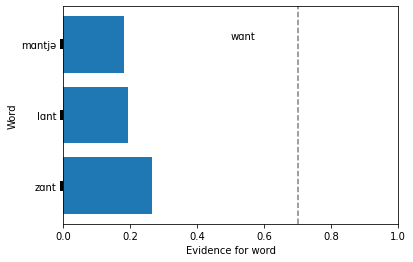

In [58]:
anim_word_idx(1338)

### Find words which are not the MAP at phoneme $k$

In [61]:
p_candidates.shape

torch.Size([2187, 1000, 16])

In [69]:
k = 5

# Only include words which are still running at phoneme $k$
mask = stim.word_lengths > k
p_candidates_masked = p_candidates.clone()
p_candidates_masked[~mask] = -torch.inf
p_candidates_argmax = p_candidates_masked[:, k].argmax(dim=1)

not_argmax_idxs = torch.where(p_candidates_argmax != 0)[0]
list(zip(not_argmax_idxs, to_gt_words(not_argmax_idxs)))

[(tensor(15), 'mojstə'),
 (tensor(27), '#dipər'),
 (tensor(37), 'heləbul'),
 (tensor(63), 'zemənsə#x'),
 (tensor(89), 'bladrə'),
 (tensor(114), '#ɑləmal#x#'),
 (tensor(175), '#idərə'),
 (tensor(228), '#ustərs'),
 (tensor(233), 'ɑndərə'),
 (tensor(238), 'zɛs#ɪs'),
 (tensor(239), 'vɛrdər'),
 (tensor(240), 'vərdində'),
 (tensor(264), 'ɑləmal#r'),
 (tensor(282), 'merə#x'),
 (tensor(456), '#pʏrpərən'),
 (tensor(506), '#maktə'),
 (tensor(529), 'xəkert#xə'),
 (tensor(592), 'xəkomə'),
 (tensor(628), 'bəwox#xə'),
 (tensor(655), 'lœkərst'),
 (tensor(865), 'vərlɑŋənt'),
 (tensor(869), 'dəxenə'),
 (tensor(898), 'kɛikə#h#'),
 (tensor(950), 'zwɔm#h'),
 (tensor(967), 'zemermɪnətjə'),
 (tensor(974), '#œyjtstrɛktə'),
 (tensor(980), 'vɛiftin'),
 (tensor(990), 'hɔndərt'),
 (tensor(996), 'herləkstə'),
 (tensor(1007), '#kɑlmə'),
 (tensor(1010), 'lɪxə#xə'),
 (tensor(1043), 'rɛijtœyjxən'),
 (tensor(1082), 'darnax'),
 (tensor(1357), 'hɔndərt'),
 (tensor(1359), 'lɑntarnsh'),
 (tensor(1423), 'zɛstin'),
 (tensor

In [71]:
anim_word_idx(37)

h
[(0.2843737857954816, 'hel'), (0.11503773708401324, 'helə'), (0.04161625407498444, 'ht'), (0.030969074349699508, 'ht'), (0.027556656173453757, 'heləbul'), (0.02208031511063773, 'hɑrt'), (0.01865259578798935, 'h'), (0.014280507235832797, 'ha'), (0.012843420209193216, 'hɑnt'), (0.010211893493392134, 'hoxə')]
h
[(0.2843737857954816, 'hel'), (0.11503773708401324, 'helə'), (0.04161625407498444, 'ht'), (0.030969074349699508, 'ht'), (0.027556656173453757, 'heləbul'), (0.02208031511063773, 'hɑrt'), (0.01865259578798935, 'h'), (0.014280507235832797, 'ha'), (0.012843420209193216, 'hɑnt'), (0.010211893493392134, 'hoxə')]
h
[(0.2843737857954816, 'hel'), (0.11503773708401324, 'helə'), (0.04161625407498444, 'ht'), (0.030969074349699508, 'ht'), (0.027556656173453757, 'heləbul'), (0.02208031511063773, 'hɑrt'), (0.01865259578798935, 'h'), (0.014280507235832797, 'ha'), (0.012843420209193216, 'hɑnt'), (0.010211893493392134, 'hoxə')]
he
[(0.6092247775663425, 'hel'), (0.24644971965575924, 'helə'), (0.059

/tmp/ipykernel_60813/4229271781.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for _, option_i in incremental_dist])
/tmp/ipykernel_60813/4229271781.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for _, option_i in incremental_dist])


helə
[(0.7967883806543204, 'helə'), (0.19086626706381407, 'heləbul'), (0.009561477370025783, 'hel'), (0.0007058671381728866, 'hɛiləxə'), (0.0005689674464068114, 'hekəl'), (0.0004017861372421666, 'hɛiləx'), (0.00020622559791568684, 'heməl'), (0.00010486451961581173, 'hetə'), (6.861690441805815e-05, 'relixjœzə'), (6.518453824514022e-05, 'penəs')]
heləb
[(0.9925745083818459, 'heləbul'), (0.0073079214554912335, 'helə'), (8.76952115707618e-05, 'hel'), (6.47401710293987e-06, 'hɛiləxə'), (5.218411199292192e-06, 'hekəl'), (3.685070721613382e-06, 'hɛiləx'), (2.3126329349481686e-06, 'xəlʏk'), (1.8914438366206418e-06, 'heməl'), (1.1957089163794259e-06, 'penəs'), (9.617882130646226e-07, 'hetə')]
heləbu
[(0.9999942516993445, 'heləbul'), (5.628860856788864e-06, 'helə'), (6.75464489793558e-08, 'hel'), (1.99462140795383e-08, 'hɛiləxə'), (5.695692165012416e-09, 'relixjœzə'), (4.6872222371597065e-09, 'relixjœs'), (4.0194343512344055e-09, 'hekəl'), (2.838392621721737e-09, 'hɛiləx'), (1.7812847446340663e-

In [34]:
p_candidates[:, 0, 3].argmin()

tensor(1824)

In [35]:
p_candidates[1824, 0, :]

tensor([4.2436e-06, 5.6206e-06, 5.6396e-06, 5.6396e-06, 5.6396e-06, 5.6396e-06,
        5.6396e-06, 5.6396e-06, 5.6396e-06, 5.6396e-06, 5.6396e-06, 5.6396e-06,
        5.6396e-06, 5.6396e-06], dtype=torch.float64)

In [39]:
stim.get_candidate_strs(1824, 1)

['ɑls']

In [32]:
p_candidates[:, 0, 0].min()

tensor(9.5920e-07, dtype=torch.float64)